In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
!pip install ftfy

# Authenticate
drive = None
def authenticate():
    global drive
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

#Download files
def downloadFiles(fileIds):
    authenticate()
    for fileId in fileIds:    
        downloaded = drive.CreateFile({"id": fileId[1]})
        downloaded.GetContentFile(fileId[0])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.5 MB/s 


In [2]:
#Download file if not existing
try:
  _ = open("bpe_simple_vocab_16e6.txt.gz", "r")
except:
  downloadFiles([["bpe_simple_vocab_16e6.txt.gz", "1sazrmZm-bsAyLap-kvFCVn8uXdGppVo-"]])

try:
  _ = open("clip_model.pt", "r")
except:
  downloadFiles([["clip_model.pt", "1UO7E2nu_4-C5RRcTtYKqCRjLPUtzV2NQ"]])


try:
  _ = open("Sample.zip", "r")
except:
  downloadFiles([["Sample.zip", "1wIUd5ojRMm1SDRHmk0aZPT63shNiK2aD"]])

import zipfile
f = zipfile.ZipFile("Sample.zip", "r")
for file in f.namelist():
    f.extract(file, "./")
f.close()

In [1]:
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
# from torchnlp import encoders
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import  mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from pathlib import Path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

import gzip
import html
import os
from functools import lru_cache

import ftfy
import regex as re

cuda


In [2]:
data_dir_cov = "Sample/Harm-C/images"
train_path_cov = "Sample/Harm-C/Harm-C-Full/train.jsonl"
dev_path_cov   = "Sample/Harm-C/Harm-C-Full/val.jsonl"
test_path_cov  = "Sample/Harm-C/Harm-C-Full/test.jsonl"

In [3]:
@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))

In [4]:
def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()


def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = "bpe_simple_vocab_16e6.txt.gz"):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text

In [5]:
# import os, sys
# sys.path.append('path_to_the_module/early-stopping-pytorch')

# 克服 EarlyStopping 问题 - https://github.com/Bjarten/early-stopping-pytorch - 下载py文件到本地
# from pytorchtools import EarlyStopping
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [6]:
clip_model = torch.jit.load("clip_model.pt").cuda().eval()
input_resolution = clip_model.input_resolution.item()
context_length = clip_model.context_length.item()
vocab_size = clip_model.vocab_size.item()

In [7]:
preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
    ])
tokenizer = SimpleTokenizer()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


In [8]:
# Get the image features for a single image input
def process_image_clip(in_img):
    image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
    image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()
    
    image = preprocess(Image.open(in_img).convert("RGB"))
    
    image_input = torch.tensor(np.stack(image)).cuda()
    image_input -= image_mean[:, None, None]
    image_input /= image_std[:, None, None]
    return image_input

# Get the text features for a single text input
def process_text_clip(in_text):    
    text_token = tokenizer.encode(in_text)
    text_input = torch.zeros(clip_model.context_length, dtype=torch.long)
    sot_token = tokenizer.encoder['<|startoftext|>']
    eot_token = tokenizer.encoder['<|endoftext|>']
    tokens = [sot_token] + text_token[:75] + [eot_token]
    text_input[:len(tokens)] = torch.tensor(tokens)
    text_input = text_input.cuda()
    return text_input

In [ ]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.5 MB/s 
     |████████████████████████████████| 4.9 MB 38.9 MB/s 
     |████████████████████████████████| 1.3 MB 49.1 MB/s 
     |████████████████████████████████| 120 kB 54.2 MB/s 
     |████████████████████████████████| 6.6 MB 48.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=ed558c60dab6ad10bd41892f4e7954b267564e2739bd4e7b5c3875a1041a22ba
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer
model_sent_trans = SentenceTransformer('paraphrase-distilroberta-base-v1')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [9]:
class HarmemeMemesDatasetAug2(torch.utils.data.Dataset):
    """Uses jsonl data to preprocess and serve 
    dictionary of multimodal tensors for model input.
    """

    def __init__(
        self,
        data_path,
        img_dir,
        split_flag=None,
        balance=False,
        dev_limit=None,
        random_state=0
        ):
      
        self.samples_frame = pd.read_json(
            data_path, lines=True
        )
        self.samples_frame = self.samples_frame.reset_index(
            drop=True
        )
        self.samples_frame.image = self.samples_frame.apply(
            lambda row: (img_dir + '/' + row.image), axis=1
        )

        
    def __len__(self):
        """This method is called when you do len(instance) 
        for an instance of this class.
        """
        return len(self.samples_frame)

    def __getitem__(self, idx):
        """This method is called when you do instance[key] 
        for an instance of this class.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = self.samples_frame.loc[idx, "id"]
        img_file_name = self.samples_frame.loc[idx, "image"]
        
        image_clip_input = process_image_clip(self.samples_frame.loc[idx, "image"])

        text_clip_input = process_text_clip(self.samples_frame.loc[idx, "text"])

        # text_drob_feature = torch.tensor(model_sent_trans.encode(self.samples_frame.loc[idx, "text"])).to(device)
        if "labels" in self.samples_frame.columns:

            if self.samples_frame.loc[idx, "labels"][0]=="not harmful":
                lab=0
            else:
                lab=1
            label = torch.tensor(lab).to(device)  


            
            sample = {
                "id": img_id, 
                "image_clip_input": image_clip_input,
                "text_clip_input": text_clip_input,
                # "text_drob_feature": text_drob_feature,
                "label": label
            }
        else:
            sample = {
                "id": img_id, 
                "image_clip_input": image_clip_input,
                "text_clip_input": text_clip_input,
            }

        return sample

In [54]:
hm_dataset_train_cov = HarmemeMemesDatasetAug2(train_path_cov, data_dir_cov, split_flag='train')
dataloader_train_cov = DataLoader(hm_dataset_train_cov, batch_size=64,
                        shuffle=True, num_workers=0)
hm_dataset_val_cov = HarmemeMemesDatasetAug2(dev_path_cov, data_dir_cov, split_flag='val')
dataloader_val_cov = DataLoader(hm_dataset_val_cov, batch_size=64,
                        shuffle=True, num_workers=0)
hm_dataset_test_cov = HarmemeMemesDatasetAug2(test_path_cov, data_dir_cov, split_flag='test')
dataloader_test_cov = DataLoader(hm_dataset_test_cov, batch_size=64,
                        shuffle=False, num_workers=0)



In [11]:
!pip install kornia
from kornia.filters import gaussian_blur2d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
class SinkhornSolver(nn.Module):
    """
    Optimal Transport solver under entropic regularisation.
    Based on the code of Gabriel Peyré.
    """
    def __init__(self, epsilon, iterations=100, ground_metric=lambda x: torch.pow(x, 2)):
        super(SinkhornSolver, self).__init__()
        self.epsilon = epsilon
        self.iterations = iterations
        self.ground_metric = ground_metric

    def forward(self, x, y):
        num_x = x.size(-2)
        num_y = y.size(-2)
        
        batch_size = 1 if x.dim() == 2 else x.size(0)

        # Marginal densities are empirical measures
        a = x.new_ones((batch_size, num_x), requires_grad=False) / num_x
        b = y.new_ones((batch_size, num_y), requires_grad=False) / num_y
        
        a = a.squeeze()
        b = b.squeeze()
                
        # Initialise approximation vectors in log domain
        u = torch.zeros_like(a)
        v = torch.zeros_like(b)

        # Stopping criterion
        threshold = 1e-1
        
        # Cost matrix
        C = self._compute_cost(x, y)
        
        # Sinkhorn iterations
        for i in range(self.iterations): 
            u0, v0 = u, v
                        
            # u^{l+1} = a / (K v^l)
            K = self._log_boltzmann_kernel(u, v, C)
            u_ = torch.log(a + 1e-8) - torch.logsumexp(K, dim=1)
            u = self.epsilon * u_ + u
                        
            # v^{l+1} = b / (K^T u^(l+1))
            K_t = self._log_boltzmann_kernel(u, v, C).transpose(-2, -1)
            v_ = torch.log(b + 1e-8) - torch.logsumexp(K_t, dim=1)
            v = self.epsilon * v_ + v
            
            # Size of the change we have performed on u
            diff = torch.sum(torch.abs(u - u0), dim=-1) + torch.sum(torch.abs(v - v0), dim=-1)
            mean_diff = torch.mean(diff)
                        
            if mean_diff.item() < threshold:
                break
   
        # print("Finished computing transport plan in {} iterations".format(i))
    
        # Transport plan pi = diag(a)*K*diag(b)
        K = self._log_boltzmann_kernel(u, v, C)
        pi = torch.exp(K)
        
        # Sinkhorn distance
        cost = torch.sum(pi * C, dim=(-2, -1))

        return cost, pi

    def _compute_cost(self, x, y):
        x_ = x.unsqueeze(-2)
        y_ = y.unsqueeze(-3)
        C = torch.sum(self.ground_metric(x_ - y_), dim=-1)
        return C

    def _log_boltzmann_kernel(self, u, v, C=None):
        C = self._compute_cost(x, y) if C is None else C
        kernel = -C + u.unsqueeze(-1) + v.unsqueeze(-2)
        kernel /= self.epsilon
        return kernel

# Define the model

In [13]:
def sinkhorn_iter(x,y):
    epsilon = 10**(-(2))
    solver = SinkhornSolver(epsilon=epsilon, iterations=10000)
    cost, pi = solver.forward(x, y)
    return cost,pi

In [14]:
test_1 = torch.randn(64,512)
test_2 = torch.randn(64,512)

In [15]:
s,pi = sinkhorn_iter(test_1,test_2)

Finished computing transport plan in 4087 iterations


In [16]:
pi.shape

torch.Size([64, 64])

In [ ]:
a = nn.Linear(64, 2).to(device)
a(F.relu(pi))

In [15]:
torch.cuda.empty_cache()

In [23]:
for data in dataloader_train_cov:
    a = data["image_clip_input"]
    b = data["text_clip_input"]
    img_feat_clip = clip_model.encode_image(a).float().to(device)
    txt_feat_clip = clip_model.encode_text(b).float().to(device)
    in_CI_smo = gaussian_blur2d(img_feat_clip.unsqueeze(0).unsqueeze(0),(3, 3), (1.5, 1.5)) #[1, 1, 64, 512]
    in_CT_smo = gaussian_blur2d(txt_feat_clip.unsqueeze(0).unsqueeze(0),(3, 3), (1.5, 1.5)) #[1, 1, 64, 512]
    cost,pi = sinkhorn_iter(in_CI_smo.squeeze(0).squeeze(0),in_CT_smo.squeeze(0).squeeze(0))
    break

Finished computing transport plan in 114 iterations


In [55]:
# Get the cross attention value features 
# Vanilla model

class MM(nn.Module):
    def __init__(self, n_out):
        super(MM, self).__init__()  
        self.dense_vgg_1024 = nn.Linear(4096, 1024)
        self.dense_vgg_512 = nn.Linear(1024, 512)
        self.drop20 = nn.Dropout(p=0.2)
        self.drop5 = nn.Dropout(p=0.05) 
        
        self.dense_drob_512 = nn.Linear(768, 512)
        
        self.gen_key_L1 = nn.Linear(512, 256) # 512X256
        self.gen_query_L1 = nn.Linear(512, 256) # 512X256
        self.gen_key_L2 = nn.Linear(512, 256) # 512X256
        self.gen_query_L2 = nn.Linear(512, 256) # 512X256
        self.gen_key_L3 = nn.Linear(512, 256) # 512X256
        self.gen_query_L3 = nn.Linear(512, 256) # 512X256
#         self.gen_value = nn.Linear(512, 256) # 512X256
        self.soft = nn.Softmax(dim=1)
        self.soft_final = nn.Softmax(dim=1)
        self.project_dense_512a = nn.Linear(1024, 512) # 512X256
        self.project_dense_512b = nn.Linear(1024, 512) # 512X256
        self.project_dense_512c = nn.Linear(1024, 512) # 512X256 
        
        
        self.fc_out = nn.Linear(512, 256) # 512X256
        self.sink_out = nn.Linear(64, 2) # 512X256
        self.out = nn.Linear(256, n_out) # 512X256
        
    def selfattNFuse(self, vec1, vec2): 
            q1 = F.relu(self.gen_query_L1(vec1))
            k1 = F.relu(self.gen_key_L1(vec1))
            q2 = F.relu(self.gen_query_L1(vec2))
            k2 = F.relu(self.gen_key_L1(vec2))
            score1 = torch.reshape(torch.bmm(q1.view(-1, 1, 256), k2.view(-1, 256, 1)), (-1, 1))
            score2 = torch.reshape(torch.bmm(q2.view(-1, 1, 256), k1.view(-1, 256, 1)), (-1, 1))
            wt_score1_score2_mat = torch.cat((score1, score2), 1)
            wt_i1_i2 = self.soft(wt_score1_score2_mat.float()) #prob
            prob_1 = wt_i1_i2[:,0]
            prob_2 = wt_i1_i2[:,1]
            wtd_i1 = vec1 * prob_1[:, None]
            wtd_i2 = vec2 * prob_2[:, None]
            out_rep = F.relu(self.project_dense_512a(torch.cat((wtd_i1,wtd_i2), 1)))
            return out_rep
  


    def forward(self, in_CI, in_CT):
        # print(in_CI.shape,in_CT.shape)
        in_CI_smo = gaussian_blur2d(in_CI.unsqueeze(0).unsqueeze(0),(3, 3), (1.5, 1.5)) #[1, 1, 64, 512]
        in_CT_smo = gaussian_blur2d(in_CT.unsqueeze(0).unsqueeze(0),(3, 3), (1.5, 1.5)) #[1, 1, 64, 512]

        cost,pi = sinkhorn_iter(in_CI_smo.squeeze(0).squeeze(0),in_CT_smo.squeeze(0).squeeze(0)) #64x64
        score_sink = F.relu(self.sink_out(pi)) #64x2
        res_inter = self.selfattNFuse(in_CI, in_CT) #64x512
        res_inter_score = F.relu(self.fc_out(res_inter)) #64x256
        res_inter_score_final = torch.sigmoid(self.out(res_inter_score)) #64x2
        score_sum = res_inter_score_final + score_sink
        return score_sum

# Training function


In [56]:
# For cross entropy loss
def train_model(model, patience, n_epochs, dataloader_train, dataloader_val):
    epochs = n_epochs
#     clip = 5

    train_acc_list=[]
    val_acc_list=[]
    train_loss_list=[]
    val_loss_list=[]
    
        # initialize the experiment path
    Path(exp_path).mkdir(parents=True, exist_ok=True)
    # initialize early_stopping object
    chk_file = os.path.join(exp_path, 'checkpoint_'+exp_name+'.pt')
    early_stopping = EarlyStopping(patience=patience, verbose=True, path=chk_file)


    model.train()
    for i in range(epochs):
#         total_acc_train = 0
        total_loss_train = 0
        total_train = 0
        correct_train = 0

        for ii,data in enumerate(dataloader_train):
            
#             Clip features...
            img_inp_clip = data['image_clip_input']
            txt_inp_clip = data['text_clip_input']
            # bert_in = data['text_drob_feature']
            with torch.no_grad():
                img_feat_clip = clip_model.encode_image(img_inp_clip).float().to(device)
                txt_feat_clip = clip_model.encode_text(txt_inp_clip).float().to(device)
                # global_img = global_feature[0].float().to(device)
                # global_txt = global_feature[1].float().to(device)

            label_train = data['label'].to(device)

            model.zero_grad()
            try:
                output = model(img_feat_clip, txt_feat_clip)
                # print(output.squeeze())
                loss = criterion(output.squeeze(), label_train)
                
                loss.backward()
    #             nn.utils.clip_grad_norm_(model.parameters(), clip)
                optimizer.step()
            

                with torch.no_grad():
                    _, predicted_train = torch.max(output.data, 1)
                    total_train += label_train.size(0)
                    correct_train += (predicted_train == label_train).sum().item()
    #                 out_val = (output.squeeze()>0.5).float()
    #                 out_final = ((out_val == 1).nonzero(as_tuple=True)[0])
    #                 print()
    #                 acc = torch.abs(output.squeeze() - label.float()).view(-1)
    #                 acc = (1. - acc.sum() / acc.size()[0])
    #                 total_acc_train += acc
                    total_loss_train += loss.item()
            except:
                pass

            if ii%5 == 0:
                print(f"epoch:{i}, batch:{ii}")

        # print(label_train,correct_train,total_train)
        train_acc = 100 * correct_train / total_train
        train_loss = total_loss_train/total_train
        model.eval()
#         total_acc_val = 0
        total_loss_val = 0
        total_val = 0
        correct_val = 0

        with torch.no_grad():
            for data in dataloader_val:                
#                 Clip features...                
                img_inp_clip = data['image_clip_input']
                txt_inp_clip = data['text_clip_input']
                # bert_in = data['text_drob_feature']
                with torch.no_grad():
                    img_feat_clip = clip_model.encode_image(img_inp_clip).float().to(device)
                    txt_feat_clip = clip_model.encode_text(txt_inp_clip).float().to(device)
                    # global_img = global_feature[0].float().to(device)
                    # global_txt = global_feature[1].float().to(device)
        
                label_val = data['label'].to(device)

                model.zero_grad()
                try:
                    output = model(img_feat_clip, txt_feat_clip)
                    
                    
                    val_loss = criterion(output.squeeze(), label_val)
                    _, predicted_val = torch.max(output.data, 1)
                    total_val += label_val.size(0)
                    correct_val += (predicted_val == label_val).sum().item()                
                    total_loss_val += val_loss.item()
                except:
                    pass

        if i == 10:
            print("Saving model...") 
            torch.save(model.state_dict(), os.path.join(exp_path, "10epoch_model.pt"))
        val_acc = 100 * correct_val / total_val
        val_loss = total_loss_val/total_val

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
            

        print(f'Epoch {i+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
        model.train()
        torch.cuda.empty_cache()
    print("Saving model...") 
    torch.save(model.state_dict(), os.path.join(exp_path, "final_model.pt"))
    # load the last checkpoint with the best model
#     model.load_state_dict(torch.load('checkpoint_1.pt'))
    
    return  model, train_acc_list, val_acc_list, train_loss_list, val_loss_list, i

In [30]:
# For CE loss
def test_model(model, dataloader_test,test_frame):
    ls_truth = []
    model.eval()
    total_test = 0
    correct_test =0
    total_acc_test = 0
    total_loss_test = 0
    outputs = []
    test_labels=[]
    with torch.no_grad():
        for i,data in enumerate(dataloader_test):
            img_inp_clip = data['image_clip_input']
            txt_inp_clip = data['text_clip_input']
            # bert_in = data['text_drob_feature']
            with torch.no_grad():
                img_feat_clip = clip_model.encode_image(img_inp_clip).float().to(device)
                txt_feat_clip = clip_model.encode_text(txt_inp_clip).float().to(device)
                # global_feature = clip_model(img_inp_clip,txt_inp_clip)
                # global_img = global_feature[0].float().to(device)
                # global_txt = global_feature[1].float().to(device)          

            label_test = data['label'].to(device)
            
#             out = model(img_feat_vgg, txt_feat_trans)        
            try:
                out = model(img_feat_clip, txt_feat_clip)        

                outputs += list(out.cpu().data.numpy())
                loss = criterion(out.squeeze(), label_test)
                
                _, predicted_test = torch.max(out.data, 1)
                total_test += label_test.size(0)
                correct_test += (predicted_test == label_test).sum().item()
    #                 out_val = (output.squeeze()>0.5).float()
    #                 out_final = ((out_val == 1).nonzero(as_tuple=True)[0])
    #                 print()
    #                 acc = torch.abs(output.squeeze() - label.float()).view(-1)
    #                 acc = (1. - acc.sum() / acc.size()[0])
    #                 total_acc_train += acc
                ls_truth.append(label_test)
            except:
                pass
            
            
#     #         print(label.float())
#             acc = torch.abs(out.squeeze() - label.float()).view(-1)
#     #         print((acc.sum() / acc.size()[0]))
#             acc = (1. - acc.sum() / acc.size()[0])
#     #         print(acc)
#             total_acc_test += acc
#             total_loss_test += loss.item()

    
    acc_test = 100 * correct_test / total_test
    loss_test = total_loss_test/total_test   

    return outputs,ls_truth


# Train

In [57]:
output_size = 2
exp_name = "EMNLP_MCHarm_GLAREAll_POLTrain_POLEval"
# pre_trn_ckp = "EMNLP_MCHarm_GLAREAll_COVTrain" # Uncomment for using pre-trained
exp_path = "path_to_saved_files/EMNLP_ModelCkpt/"+exp_name
lr=0.0007
# criterion = nn.BCELoss() #Binary case
criterion = nn.CrossEntropyLoss()
# # ------------Fresh training------------
model = MM(output_size)
model.to(device)
# print(model_harm_p)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

n_epochs = 3
# early stopping patience; how long to wait after last time validation loss improved.
patience = 25
model_harm_c, train_acc_list_cov, val_acc_list_cov, train_loss_list_cov, val_loss_list_cov, epoc_num = train_model(model, patience,
                                                                                            n_epochs,dataloader_train_cov,
                                                                                            dataloader_val_cov)

epoch:0, batch:0
epoch:0, batch:5
epoch:0, batch:10
epoch:0, batch:15
epoch:0, batch:20
epoch:0, batch:25
epoch:0, batch:30
epoch:0, batch:35
epoch:0, batch:40
epoch:0, batch:45
Validation loss decreased (inf --> 0.009362).  Saving model ...
Epoch 1: train_loss: 0.0087 train_acc: 75.0332 | val_loss: 0.0094 val_acc: 69.5312
epoch:1, batch:0
epoch:1, batch:5
epoch:1, batch:10
epoch:1, batch:15
epoch:1, batch:20
epoch:1, batch:25
epoch:1, batch:30
epoch:1, batch:35
epoch:1, batch:40
epoch:1, batch:45
Validation loss decreased (0.009362 --> 0.008370).  Saving model ...
Epoch 2: train_loss: 0.0075 train_acc: 83.0120 | val_loss: 0.0084 val_acc: 76.5625
epoch:2, batch:0
epoch:2, batch:5
epoch:2, batch:10
epoch:2, batch:15
epoch:2, batch:20
epoch:2, batch:25
epoch:2, batch:30
epoch:2, batch:35
epoch:2, batch:40
epoch:2, batch:45
EarlyStopping counter: 1 out of 25
Epoch 3: train_loss: 0.0070 train_acc: 86.2367 | val_loss: 0.0085 val_acc: 76.5625
Saving model...


In [83]:
torch.save(model_harm_c,"stage2-2_f182.pt")

In [70]:
n_epochs = 1
# early stopping patience; how long to wait after last time validation loss improved.
patience = 25
model_harm_c, train_acc_list_cov, val_acc_list_cov, train_loss_list_cov, val_loss_list_cov, epoc_num = train_model(model, patience,
                                                                                            n_epochs,dataloader_train_cov,
                                                                                            dataloader_val_cov)

epoch:0, batch:0
epoch:0, batch:5
epoch:0, batch:10
epoch:0, batch:15
epoch:0, batch:20
epoch:0, batch:25
epoch:0, batch:30
epoch:0, batch:35
epoch:0, batch:40
epoch:0, batch:45
Validation loss decreased (inf --> 0.008447).  Saving model ...
Epoch 1: train_loss: 0.0067 train_acc: 88.6303 | val_loss: 0.0084 val_acc: 76.5625
Saving model...


In [82]:
torch.save(model_harm_c,"stage2-2.pt")

In [37]:
def model_evaluation(model, dataloader_test, test_samples_frame, model_name):
    outputs,ls_truth = test_model(model, dataloader_test,test_samples_frame)
    # Multiclass setting - Harmful
    y_pred=[]
    for i in outputs:
    #     print(np.argmax(i))
        y_pred.append(np.argmax(i))
    # # np.argmax(outputs[:])
    # outputs

    # # Multiclass setting
    aa = []
    for batch in ls_truth:
        aa+=batch

    return y_pred, aa

In [38]:
test_samples_frame_cov = pd.read_json(test_path_cov, lines=True)

In [71]:
y_pred,aa = model_evaluation(model_harm_c, dataloader_test_cov, test_samples_frame_cov,"Stage 2-2")

In [72]:
ls = []
for i in aa:
    ls.append(i.item())
    

In [ ]:
y_pred

In [73]:
rec = np.round(recall_score(ls, y_pred, average="macro"),4)
prec = np.round(precision_score(ls, y_pred, average="macro"),4)
f1 = np.round(f1_score(ls, y_pred, average="macro"),4)
# hl = np.round(hamming_loss(test_labels, y_pred),4)
acc = np.round(accuracy_score(ls, y_pred),4)
mae = np.round(mean_absolute_error(ls, y_pred),4)
print("recall_score\t: ",rec)
print("precision_score\t: ",prec)
print("f1_score\t: ",f1)
# print("hamming_loss\t: ",hl)
# print("accuracy_score\t: ",f1)
print(classification_report(ls, y_pred))


recall_score	:  0.8368
precision_score	:  0.8199
f1_score	:  0.8192
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       196
           1       0.71      0.90      0.80       124

    accuracy                           0.82       320
   macro avg       0.82      0.84      0.82       320
weighted avg       0.84      0.82      0.82       320



In [79]:
output_size = 2
exp_name = "EMNLP_MCHarm_GLAREAll_POLTrain_POLEval"
# pre_trn_ckp = "EMNLP_MCHarm_GLAREAll_COVTrain" # Uncomment for using pre-trained
exp_path = "path_to_saved_files/EMNLP_ModelCkpt/"+exp_name
lr=0.0007
# criterion = nn.BCELoss() #Binary case
criterion = nn.CrossEntropyLoss()
# # ------------Fresh training------------
model_2_2_test = MM(output_size)
model_2_2_test.to(device)
# print(model_harm_p)
optimizer = torch.optim.Adam(model_2_2_test.parameters(), lr=lr, weight_decay=1e-5)

n_epochs = 25
# early stopping patience; how long to wait after last time validation loss improved.
patience = 25
model_2_2_test, train_acc_list_cov, val_acc_list_cov, train_loss_list_cov, val_loss_list_cov, epoc_num = train_model(model_2_2_test, patience,
                                                                                            n_epochs,dataloader_train_cov,
                                                                                            dataloader_val_cov)

epoch:0, batch:0
epoch:0, batch:5
epoch:0, batch:10
epoch:0, batch:15
epoch:0, batch:20
epoch:0, batch:25
epoch:0, batch:30
epoch:0, batch:35
epoch:0, batch:40
epoch:0, batch:45
Validation loss decreased (inf --> 0.009252).  Saving model ...
Epoch 1: train_loss: 0.0086 train_acc: 76.1636 | val_loss: 0.0093 val_acc: 69.5312
epoch:1, batch:0
epoch:1, batch:5
epoch:1, batch:10
epoch:1, batch:15
epoch:1, batch:20
epoch:1, batch:25
epoch:1, batch:30
epoch:1, batch:35
epoch:1, batch:40
epoch:1, batch:45
EarlyStopping counter: 1 out of 25
Epoch 2: train_loss: 0.0074 train_acc: 84.0426 | val_loss: 0.0097 val_acc: 69.5312
epoch:2, batch:0
epoch:2, batch:5
epoch:2, batch:10
epoch:2, batch:15
epoch:2, batch:20
epoch:2, batch:25
epoch:2, batch:30
epoch:2, batch:35
epoch:2, batch:40
epoch:2, batch:45
Validation loss decreased (0.009252 --> 0.008765).  Saving model ...
Epoch 3: train_loss: 0.0070 train_acc: 86.6024 | val_loss: 0.0088 val_acc: 75.7812
epoch:3, batch:0
epoch:3, batch:5
epoch:3, batch:

In [80]:
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
epochs = range(epoc_num+1)
# train_acc_list
# val_acc_list
# train_loss_list
# val_loss_list
# plt.plot(epochs, train_acc_list)
# plt.plot(epochs, val_acc_list)
def plot_train_info(train_acc_list, val_acc_list,train_loss_list, val_loss_list):
    fig1, ax1 = plt.subplots()
    ax1.plot(epochs, train_acc_list, label="train acc")
    ax1.plot(epochs, val_acc_list, label="val acc")
    ax1.set_title("accuracy plot")
    ax1.set_xlabel("epochs")
    ax1.legend(loc="upper left")
    fig2, ax2 = plt.subplots()
    ax2.plot(epochs, train_loss_list, label="train loss")
    ax2.plot(epochs, val_loss_list, label="val loss")
    ax2.set_title("loss plot")
    ax2.set_xlabel("epochs")
    ax2.legend(loc="upper left")

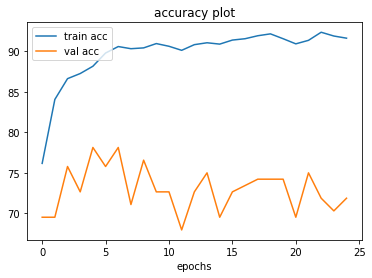

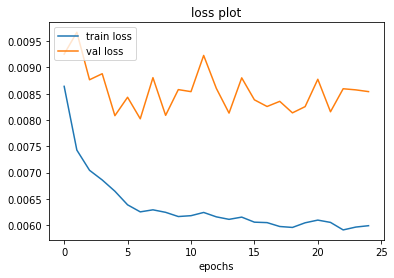

In [81]:
plot_train_info(train_acc_list_cov, val_acc_list_cov,train_loss_list_cov, val_loss_list_cov)

In [78]:
y_pred,aa = model_evaluation(model_2_2_test, dataloader_test_cov, test_samples_frame_cov,"Stage 2-2")
ls = []
for i in aa:
    ls.append(i.item())
rec = np.round(recall_score(ls, y_pred, average="macro"),4)
prec = np.round(precision_score(ls, y_pred, average="macro"),4)
f1 = np.round(f1_score(ls, y_pred, average="macro"),4)
# hl = np.round(hamming_loss(test_labels, y_pred),4)
acc = np.round(accuracy_score(ls, y_pred),4)
mae = np.round(mean_absolute_error(ls, y_pred),4)
print("recall_score\t: ",rec)
print("precision_score\t: ",prec)
print("f1_score\t: ",f1)
# print("hamming_loss\t: ",hl)
# print("accuracy_score\t: ",f1)
print(classification_report(ls, y_pred))

recall_score	:  0.8152
precision_score	:  0.8004
f1_score	:  0.8022
              precision    recall  f1-score   support

           0       0.89      0.78      0.83       196
           1       0.71      0.85      0.77       124

    accuracy                           0.81       320
   macro avg       0.80      0.82      0.80       320
weighted avg       0.82      0.81      0.81       320

